In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k

#### Visualization Functions

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#### Import Data

In [3]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

/opt/anaconda3/bin/python: Error while finding module specification for 'tensorflow_datasets.scripts.download_and_prepare' (ModuleNotFoundError: No module named 'tensorflow_datasets')


#### Data Preprocessing

In [4]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [5]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [6]:
vocabulary_size = 1000
output_sequence_length=96

In [7]:
text_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode="int",
    output_sequence_length=output_sequence_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

#### Experiment 1 - 1D CNN

In [8]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
encoded = tf.one_hot(inputs, depth=vocabulary_size)
conv = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(encoded)
max_pooling = layers.MaxPooling1D(pool_size=2)(conv)
global_max_pooling = layers.GlobalMaxPooling1D()(max_pooling)
dense = layers.Dense(64, activation='relu')(global_max_pooling)
outputs = layers.Dense(4, activation="softmax")(dense)
model_one = tf.keras.Model(inputs, outputs)

model_one.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_one.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_one =model_one.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_one = keras.models.load_model("model_one.h5")

pred_one = np.argmax(model_one.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 26s 7ms/step - loss: 0.5639 - accuracy: 0.8025 - val_loss: 0.4427 - val_accuracy: 0.8480
Epoch 2/200
  17/3563 [..............................] - ETA: 24s - loss: 0.4173 - accuracy: 0.8566

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 25s 7ms/step - loss: 0.4369 - accuracy: 0.8466 - val_loss: 0.4303 - val_accuracy: 0.8508
Epoch 3/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4244 - accuracy: 0.8501 - val_loss: 0.4257 - val_accuracy: 0.8518
Epoch 4/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4174 - accuracy: 0.8529 - val_loss: 0.4239 - val_accuracy: 0.8537
Epoch 5/200
3563/3563 [==============================] - 25s 7ms/step - loss: 0.4122 - accuracy: 0.8542 - val_loss: 0.4220 - val_accuracy: 0.8570
Epoch 6/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4088 - accuracy: 0.8553 - val_loss: 0.4191 - val_accuracy: 0.8578
Epoch 7/200
3563/3563 [==============================] - 25s 7ms/step - loss: 0.4069 - accuracy: 0.8563 - val_loss: 0.4193 - val_accuracy: 0.8562
Epoch 8/200
3563/3563 [==============================] - 25s 7ms/step - loss: 0.4062 - accuracy: 0.8560 - val_loss: 0.4192 - val_accurac

#### Experiment 2

In [9]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
conv = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(embedding)
max_pooling = layers.MaxPooling1D(pool_size=2)(conv)
global_max_pooling = layers.GlobalMaxPooling1D()(conv)
dense = layers.Dense(64, activation='relu')(global_max_pooling)
outputs = layers.Dense(4, activation="softmax")(dense)
model_two = tf.keras.Model(inputs, outputs)

model_two.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_two.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_two =model_two.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_two = keras.models.load_model("model_two.h5")

pred_two = np.argmax(model_two.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 39s 11ms/step - loss: 0.4763 - accuracy: 0.8294 - val_loss: 0.4160 - val_accuracy: 0.8537
Epoch 2/200
3563/3563 [==============================] - 47s 13ms/step - loss: 0.4183 - accuracy: 0.8521 - val_loss: 0.4179 - val_accuracy: 0.8517
Epoch 3/200
3563/3563 [==============================] - 49s 14ms/step - loss: 0.4101 - accuracy: 0.8554 - val_loss: 0.4227 - val_accuracy: 0.8535
Epoch 4/200
3563/3563 [==============================] - 48s 13ms/step - loss: 0.4112 - accuracy: 0.8561 - val_loss: 0.4307 - val_accuracy: 0.8543
Epoch 5/200
3563/3563 [==============================] - 41s 11ms/step - loss: 0.4172 - accuracy: 0.8548 - val_loss: 0.4382 - val_accuracy: 0.8513
Epoch 6/200
3563/3563 [==============================] - 37s 10ms/step - loss: 0.4278 - accuracy: 0.8521 - val_loss: 0.4508 - val_accuracy: 0.8423
Epoch 7/200
238/238 [==============================] - 1s 3ms/step


#### Experiment 3

In [10]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
dropout = layers.Dropout(0.3)(embedding)
conv = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(dropout)
dropout = layers.Dropout(0.3)(conv)
max_pooling = layers.MaxPooling1D(pool_size=2)(dropout)
dropout = layers.Dropout(0.3)(max_pooling)
global_max_pooling = layers.GlobalMaxPooling1D()(dropout)
dropout = layers.Dropout(0.3)(global_max_pooling)
dense = layers.Dense(64, activation='relu')(dropout)
outputs = layers.Dense(4, activation="softmax")(dense)
model_three = tf.keras.Model(inputs, outputs)

model_three.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_three.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_three =model_three.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_three = keras.models.load_model("model_three.h5")

pred_three = np.argmax(model_three.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 49s 14ms/step - loss: 0.6123 - accuracy: 0.7798 - val_loss: 0.6194 - val_accuracy: 0.8228
Epoch 2/200
3563/3563 [==============================] - 49s 14ms/step - loss: 0.5451 - accuracy: 0.8081 - val_loss: 0.5952 - val_accuracy: 0.8322
Epoch 3/200
3563/3563 [==============================] - 49s 14ms/step - loss: 0.5414 - accuracy: 0.8120 - val_loss: 0.5818 - val_accuracy: 0.8302
Epoch 4/200
3563/3563 [==============================] - 49s 14ms/step - loss: 0.5413 - accuracy: 0.8121 - val_loss: 0.5352 - val_accuracy: 0.8430
Epoch 5/200
3563/3563 [==============================] - 50s 14ms/step - loss: 0.5409 - accuracy: 0.8140 - val_loss: 0.5247 - val_accuracy: 0.8423
Epoch 6/200
3563/3563 [==============================] - 117s 33ms/step - loss: 0.5393 - accuracy: 0.8138 - val_loss: 0.5238 - val_accuracy: 0.8433
Epoch 7/200
3563/3563 [==============================] - 74s 21ms/step - loss: 0.5365 - accuracy: 0.8155 - val_loss: 

#### Experiment 4

In [11]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
recurrent = layers.SimpleRNN(units=32)(embedding)
dense = layers.Dense(64, activation='relu')(recurrent)
outputs = layers.Dense(4, activation="softmax")(dense)
model_four = tf.keras.Model(inputs, outputs)

model_four.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_four.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_four = model_four.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_four = keras.models.load_model("model_four.h5")

pred_four = np.argmax(model_four.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 339s 95ms/step - loss: 1.3884 - accuracy: 0.2505 - val_loss: 1.3873 - val_accuracy: 0.2515
Epoch 2/200
3563/3563 [==============================] - 124s 35ms/step - loss: 1.3871 - accuracy: 0.2513 - val_loss: 1.3877 - val_accuracy: 0.2515
Epoch 3/200
3563/3563 [==============================] - 125s 35ms/step - loss: 1.3869 - accuracy: 0.2516 - val_loss: 1.3876 - val_accuracy: 0.2515
Epoch 4/200
3563/3563 [==============================] - 125s 35ms/step - loss: 1.3870 - accuracy: 0.2514 - val_loss: 1.3868 - val_accuracy: 0.2517
Epoch 5/200
3563/3563 [==============================] - 126s 35ms/step - loss: 1.3865 - accuracy: 0.2521 - val_loss: 1.3864 - val_accuracy: 0.2517
Epoch 6/200
3563/3563 [==============================] - 128s 36ms/step - loss: 1.3866 - accuracy: 0.2498 - val_loss: 1.3864 - val_accuracy: 0.2517
Epoch 7/200
238/238 [==============================] - 3s 10ms/step


#### Experiment 5

In [12]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
rnn_bidirectional = layers.Bidirectional(layers.SimpleRNN(units=32))(embedding)
dense = layers.Dense(64, activation='relu')(rnn_bidirectional)
outputs = layers.Dense(4, activation="softmax")(dense)
model_five = tf.keras.Model(inputs, outputs)

model_five.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_five.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_five = model_five.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_five = keras.models.load_model("model_five.h5")

pred_five = np.argmax(model_five.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 205s 57ms/step - loss: 0.5147 - accuracy: 0.8159 - val_loss: 0.4455 - val_accuracy: 0.8467
Epoch 2/200
3563/3563 [==============================] - 210s 59ms/step - loss: 0.4420 - accuracy: 0.8443 - val_loss: 0.4406 - val_accuracy: 0.8452
Epoch 3/200
3563/3563 [==============================] - 214s 60ms/step - loss: 0.4273 - accuracy: 0.8495 - val_loss: 0.4505 - val_accuracy: 0.8433
Epoch 4/200
238/238 [==============================] - 3s 13ms/step


#### Experiment 6

In [13]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
dropout = layers.Dropout(0.3)(embedding)
rnn_bidirectional = layers.Bidirectional(layers.SimpleRNN(units=32))(dropout)
dropout = layers.Dropout(0.3)(rnn_bidirectional)
dense = layers.Dense(64, activation='relu')(dropout)
dropout = layers.Dropout(0.3)(dense)
outputs = layers.Dense(4, activation="softmax")(dropout)
model_six = tf.keras.Model(inputs, outputs)

model_six.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_six.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_six = model_six.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_six = keras.models.load_model("model_six.h5")

pred_six = np.argmax(model_six.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 216s 60ms/step - loss: 0.5921 - accuracy: 0.7873 - val_loss: 0.4432 - val_accuracy: 0.8398
Epoch 2/200
3563/3563 [==============================] - 219s 62ms/step - loss: 0.4947 - accuracy: 0.8328 - val_loss: 0.4338 - val_accuracy: 0.8493
Epoch 3/200
3563/3563 [==============================] - 217s 61ms/step - loss: 0.4833 - accuracy: 0.8380 - val_loss: 0.4445 - val_accuracy: 0.8460
Epoch 4/200
3563/3563 [==============================] - 217s 61ms/step - loss: 0.4832 - accuracy: 0.8382 - val_loss: 0.4455 - val_accuracy: 0.8428
Epoch 5/200
238/238 [==============================] - 3s 13ms/step


#### Experiment 7

In [24]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
lstm = layers.LSTM(units=32)(embedding)
dense = layers.Dense(64, activation='relu')(lstm)
outputs = layers.Dense(4, activation="softmax")(dense)
model_seven = tf.keras.Model(inputs, outputs)

model_seven.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_seven.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_seven = model_seven.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_seven = keras.models.load_model("model_seven.h5")

pred_seven = np.argmax(model_seven.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 262s 73ms/step - loss: 1.3867 - accuracy: 0.2510 - val_loss: 1.3865 - val_accuracy: 0.2515
Epoch 2/200
   2/3563 [..............................] - ETA: 3:56 - loss: 1.3853 - accuracy: 0.3281

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 258s 72ms/step - loss: 1.3864 - accuracy: 0.2506 - val_loss: 1.3864 - val_accuracy: 0.2515
Epoch 3/200
3563/3563 [==============================] - 240s 67ms/step - loss: 1.3864 - accuracy: 0.2506 - val_loss: 1.3864 - val_accuracy: 0.2515
Epoch 4/200
238/238 [==============================] - 4s 15ms/step


#### Experiment 8

In [26]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
lstm_bidirectional = layers.Bidirectional(layers.LSTM(units=32))(embedding)
dense = layers.Dense(64, activation='relu')(lstm_bidirectional)
outputs = layers.Dense(4, activation="softmax")(dense)
model_eight = tf.keras.Model(inputs, outputs)

model_eight.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_eight.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_eight = model_eight.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_eight = keras.models.load_model("model_eight.h5")

pred_eight = np.argmax(model_eight.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 278s 78ms/step - loss: 0.4443 - accuracy: 0.8395 - val_loss: 0.3910 - val_accuracy: 0.8620
Epoch 2/200
3563/3563 [==============================] - 282s 79ms/step - loss: 0.3860 - accuracy: 0.8609 - val_loss: 0.3780 - val_accuracy: 0.8645
Epoch 3/200
3563/3563 [==============================] - 283s 79ms/step - loss: 0.3668 - accuracy: 0.8675 - val_loss: 0.3777 - val_accuracy: 0.8665
Epoch 4/200
3563/3563 [==============================] - 286s 80ms/step - loss: 0.3554 - accuracy: 0.8726 - val_loss: 0.3829 - val_accuracy: 0.8672
Epoch 5/200
3563/3563 [==============================] - 271s 76ms/step - loss: 0.3471 - accuracy: 0.8773 - val_loss: 0.4026 - val_accuracy: 0.8650
Epoch 6/200
238/238 [==============================] - 5s 18ms/step


#### Experiment 9

In [28]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=vocabulary_size)(inputs)
dropout = layers.Dropout(0.3)(embedding)
lstm_bidirectional = layers.Bidirectional(layers.LSTM(units=32))(dropout)
dropout = layers.Dropout(0.3)(lstm_bidirectional)
dense = layers.Dense(64, activation='relu')(dropout)
dropout = layers.Dropout(0.3)(dense)
outputs = layers.Dense(4, activation="softmax")(dropout)
model_nine = tf.keras.Model(inputs, outputs)

model_nine.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_nine.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

history_nine = model_nine.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

model_nine = keras.models.load_model("model_nine.h5")

pred_nine = np.argmax(model_nine.predict(int_test_ds), axis=-1)

Epoch 1/200
3563/3563 [==============================] - 278s 78ms/step - loss: 0.4916 - accuracy: 0.8266 - val_loss: 0.4056 - val_accuracy: 0.8570
Epoch 2/200
   2/3563 [..............................] - ETA: 4:41 - loss: 0.4301 - accuracy: 0.8438

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 277s 78ms/step - loss: 0.4274 - accuracy: 0.8533 - val_loss: 0.3913 - val_accuracy: 0.8618
Epoch 3/200
3563/3563 [==============================] - 281s 79ms/step - loss: 0.4176 - accuracy: 0.8574 - val_loss: 0.3956 - val_accuracy: 0.8632
Epoch 4/200
3563/3563 [==============================] - 279s 78ms/step - loss: 0.4104 - accuracy: 0.8602 - val_loss: 0.3909 - val_accuracy: 0.8657
Epoch 5/200
3563/3563 [==============================] - 281s 79ms/step - loss: 0.4070 - accuracy: 0.8617 - val_loss: 0.3917 - val_accuracy: 0.8705
Epoch 6/200
3563/3563 [==============================] - 282s 79ms/step - loss: 0.4052 - accuracy: 0.8636 - val_loss: 0.3935 - val_accuracy: 0.8683
Epoch 7/200
3563/3563 [==============================] - 280s 79ms/step - loss: 0.4028 - accuracy: 0.8653 - val_loss: 0.4020 - val_accuracy: 0.8657
Epoch 8/200
238/238 [==============================] - 5s 18ms/step


#### Experiment 10

#### Results

In [30]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)

In [31]:
preds_df = pd.DataFrame({
    'model_one':pred_one,
    'model_two':pred_two,
    'model_three':pred_three,
    'model_four':pred_four,
    'model_five':pred_five,
    'model_six':pred_six,
    'model_seven':pred_seven,
    'model_eight':pred_eight,
    'model_nine':pred_nine,
    #'model_tem':pred_ten,
})

preds_df.to_excel('model_preds.xlsx')

In [32]:
preds_df_xl = pd.read_excel('model_preds.xlsx')

pred_one_xl = preds_df.loc[:,'model_one']
pred_two_xl = preds_df.loc[:,'model_two']
pred_three_xl = preds_df.loc[:,'model_three']
pred_four_xl = preds_df.loc[:,'model_four']
pred_five_xl = preds_df.loc[:,'model_five']
pred_six_xl = preds_df.loc[:,'model_six']
pred_seven_xl = preds_df.loc[:,'model_seven']
pred_eight_xl = preds_df.loc[:,'model_eight']
pred_nine_xl = preds_df.loc[:,'model_nine']
#pred_ten_xl = preds_df.loc[:,'model_ten']

In [29]:
def create_results_dataframe(model_name,training_history,y_true,y_pred):
    training_history_df = pd.DataFrame(training_history.history)
    best_model = training_history_df.iloc[-1:,]
    best_model = best_model.reset_index().rename(columns={'index':'epoch','loss':'training_loss','accuracy':'training_accuracy'})

    best_model['test_accuracy'] = accuracy_score(y_true,y_pred)
    best_model['precision_micro'] = precision_score(y_true,y_pred,average='micro')
    best_model['recall_micro'] = recall_score(y_true,y_pred,average='micro')
    best_model['f1_score_micro'] = f1_score(y_true,y_pred,average='micro')

    best_model['model_name'] = model_name

    results = best_model.iloc[:,[-1,0,1,2,3,4,5,6,7,8]]

    return(results)

In [33]:
experiment_results = pd.DataFrame(columns=['model','epoch','accuracy','loss','precision_micro','recall_micro','f1_score_micro'])

experiment_1_results = create_results_dataframe('model_one',history_one,y_test,pred_one)
experiment_2_results = create_results_dataframe('model_two',history_two,y_test,pred_two)
experiment_3_results = create_results_dataframe('model_three',history_three,y_test,pred_three)
experiment_4_results = create_results_dataframe('model_four',history_four,y_test,pred_four)
experiment_5_results = create_results_dataframe('model_five',history_five,y_test,pred_five)
experiment_6_results = create_results_dataframe('model_six',history_six,y_test,pred_six)
experiment_7_results = create_results_dataframe('model_seven',history_seven,y_test,pred_seven)
experiment_8_results = create_results_dataframe('model_eight',history_eight,y_test,pred_eight)
experiment_9_results = create_results_dataframe('model_nine',history_nine,y_test,pred_nine)
#experiment_9_results = create_results_dataframe('model_ten',history_ten,y_test,pred_ten)

experiment_results = pd.concat([
    experiment_1_results,
    experiment_2_results,
    experiment_3_results,
    experiment_4_results,
    experiment_5_results,
    experiment_6_results,
    experiment_7_results,
    experiment_8_results,
    experiment_9_results,
    #experiment_10_results,
    ]).reset_index(drop=True)

experiment_results['training_time'] = [
    '3:42',
    '4:58',
    '13:21',
    '18:20',
    '13:59',
    '18:10',
    '16:55',
    '27:54',
    '37:27',
    #''
]

experiment_results

,model_name,epoch,training_loss,training_accuracy,val_loss,val_accuracy,test_accuracy,precision_micro,recall_micro,f1_score_micro,training_time
0,model_one,8,0.405574,0.857175,0.422060,0.856167,0.849342,0.849342,0.849342,0.849342,3:42
1,model_two,6,0.439694,0.848947,0.463638,0.843333,0.848026,0.848026,0.848026,0.848026,4:58
2,model_three,8,0.538734,0.815096,0.577992,0.826333,0.835263,0.835263,0.835263,0.835263,13:21
3,model_four,6,1.386520,0.250930,1.386427,0.251667,0.250000,0.250000,0.250000,0.250000,18:20
4,model_five,3,0.425001,0.851807,0.459653,0.843167,0.843421,0.843421,0.843421,0.843421,13:59
5,model_six,4,0.481034,0.840921,0.446165,0.845833,0.844737,0.844737,0.844737,0.844737,18:10
6,model_seven,3,1.386363,0.250702,1.386429,0.251500,0.250000,0.250000,0.250000,0.250000,16:55
7,model_eight,5,0.339734,0.880605,0.413856,0.862833,0.864079,0.864079,0.864079,0.864079,27:54
8,model_nine,7,0.402147,0.866211,0.406132,0.866833,0.860263,0.860263,0.860263,0.860263,


In [34]:
def plot_training_history(history_list,n):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # Adjust for 3 models

    for i, history in enumerate(history_list):
        row_idx = i // 3  # Adjust for 3 models
        col_idx = i % 3  # Adjust for 3 models

        training_accuracy = history.history['accuracy']
        validation_accuracy = history.history['val_accuracy']
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']

        # Plot training accuracy against validation accuracy
        axes[row_idx, col_idx].plot(training_accuracy, label='Training Accuracy')
        axes[row_idx, col_idx].plot(validation_accuracy, label='Validation Accuracy')
        axes[row_idx, col_idx].set_xlabel('Epochs')
        axes[row_idx, col_idx].set_ylabel('Accuracy')
        axes[row_idx, col_idx].set_title(f'Model {n + i + 1} Accuracy')
        axes[row_idx, col_idx].legend()

        # Plot training loss against validation loss
        axes[row_idx + 1, col_idx].plot(training_loss, label='Training Loss')
        axes[row_idx + 1, col_idx].plot(validation_loss, label='Validation Loss')
        axes[row_idx + 1, col_idx].set_xlabel('Epochs')
        axes[row_idx + 1, col_idx].set_ylabel('Loss')
        axes[row_idx + 1, col_idx].set_title(f'Model {n + i + 1} Loss')
        axes[row_idx + 1, col_idx].legend()

    # Adjust layout and display the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

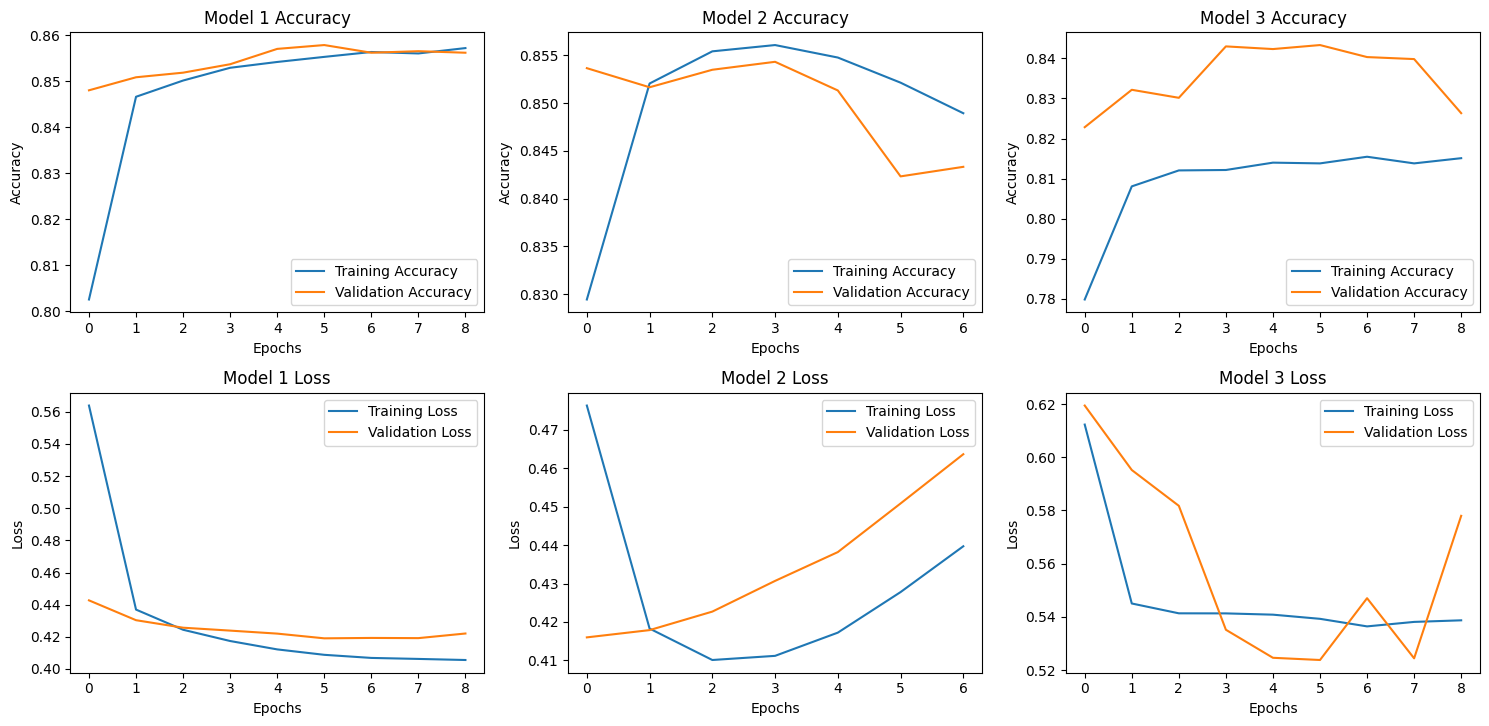

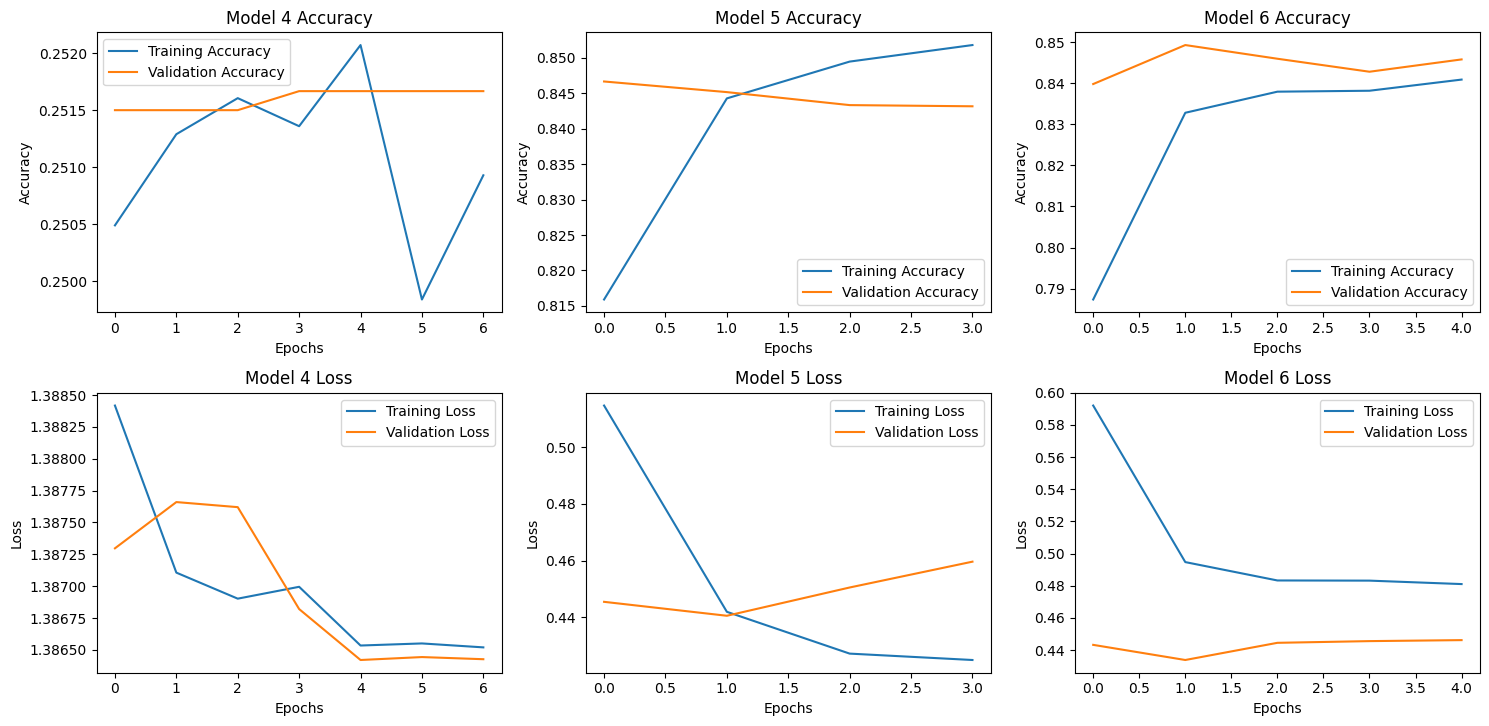

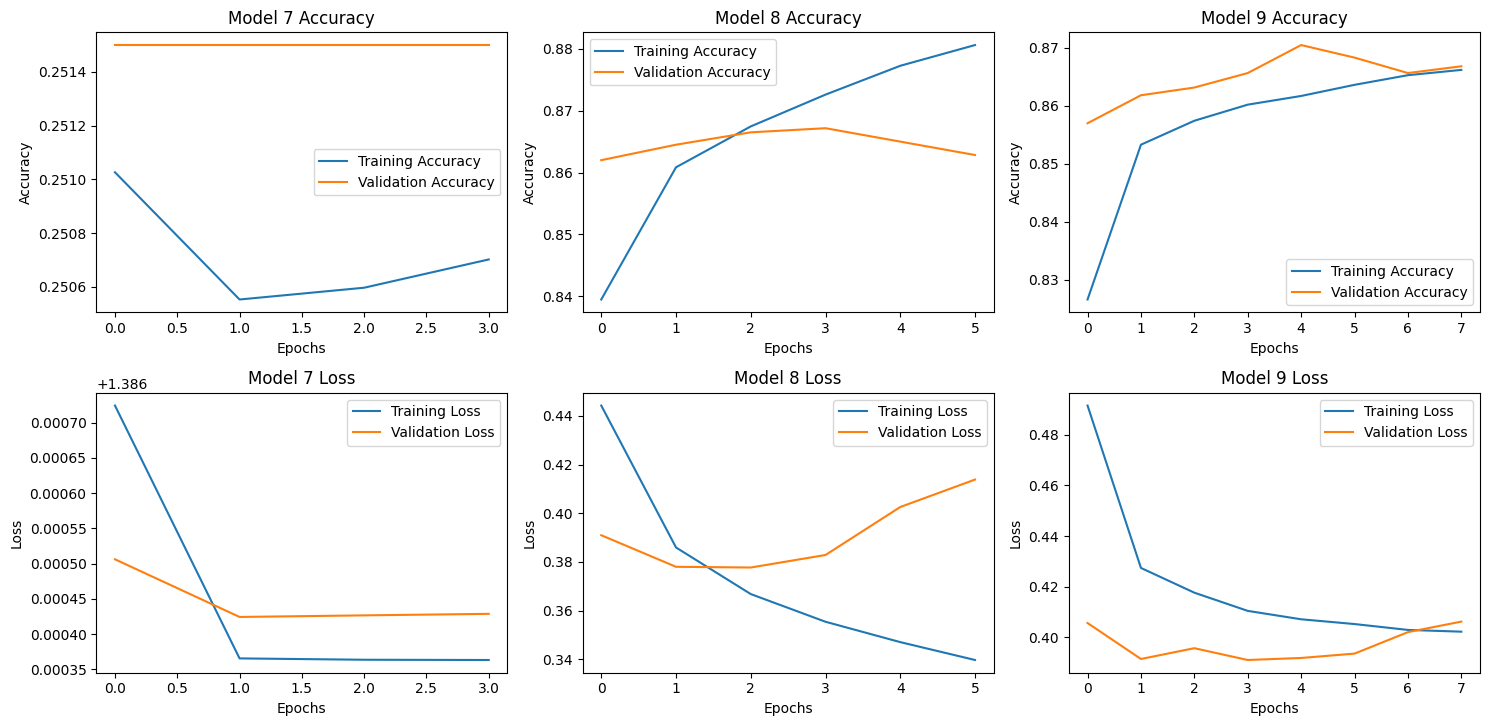

In [40]:
plot_training_history([history_one,history_two,history_three],0)
plot_training_history([history_four,history_five,history_six],3)
plot_training_history([history_seven,history_eight,history_nine],6)

In [38]:
def plot_confusion_matrices(y_preds, y_true):
    num_sets = len(y_preds)
    cols = min(3, num_sets)  # Changed from 4 to 3
    rows = (num_sets + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), squeeze=False)

    for i, (y_pred, ax) in enumerate(zip(y_preds, axs.flat)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=np.unique(y_true), yticklabels=np.unique(y_true), ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(f"Model {i+1}")

    # Remove any empty subplots in the bottom row
    for i in range(num_sets, rows * cols):
        axs.flat[i].axis("off")

    plt.tight_layout()
    plt.show()

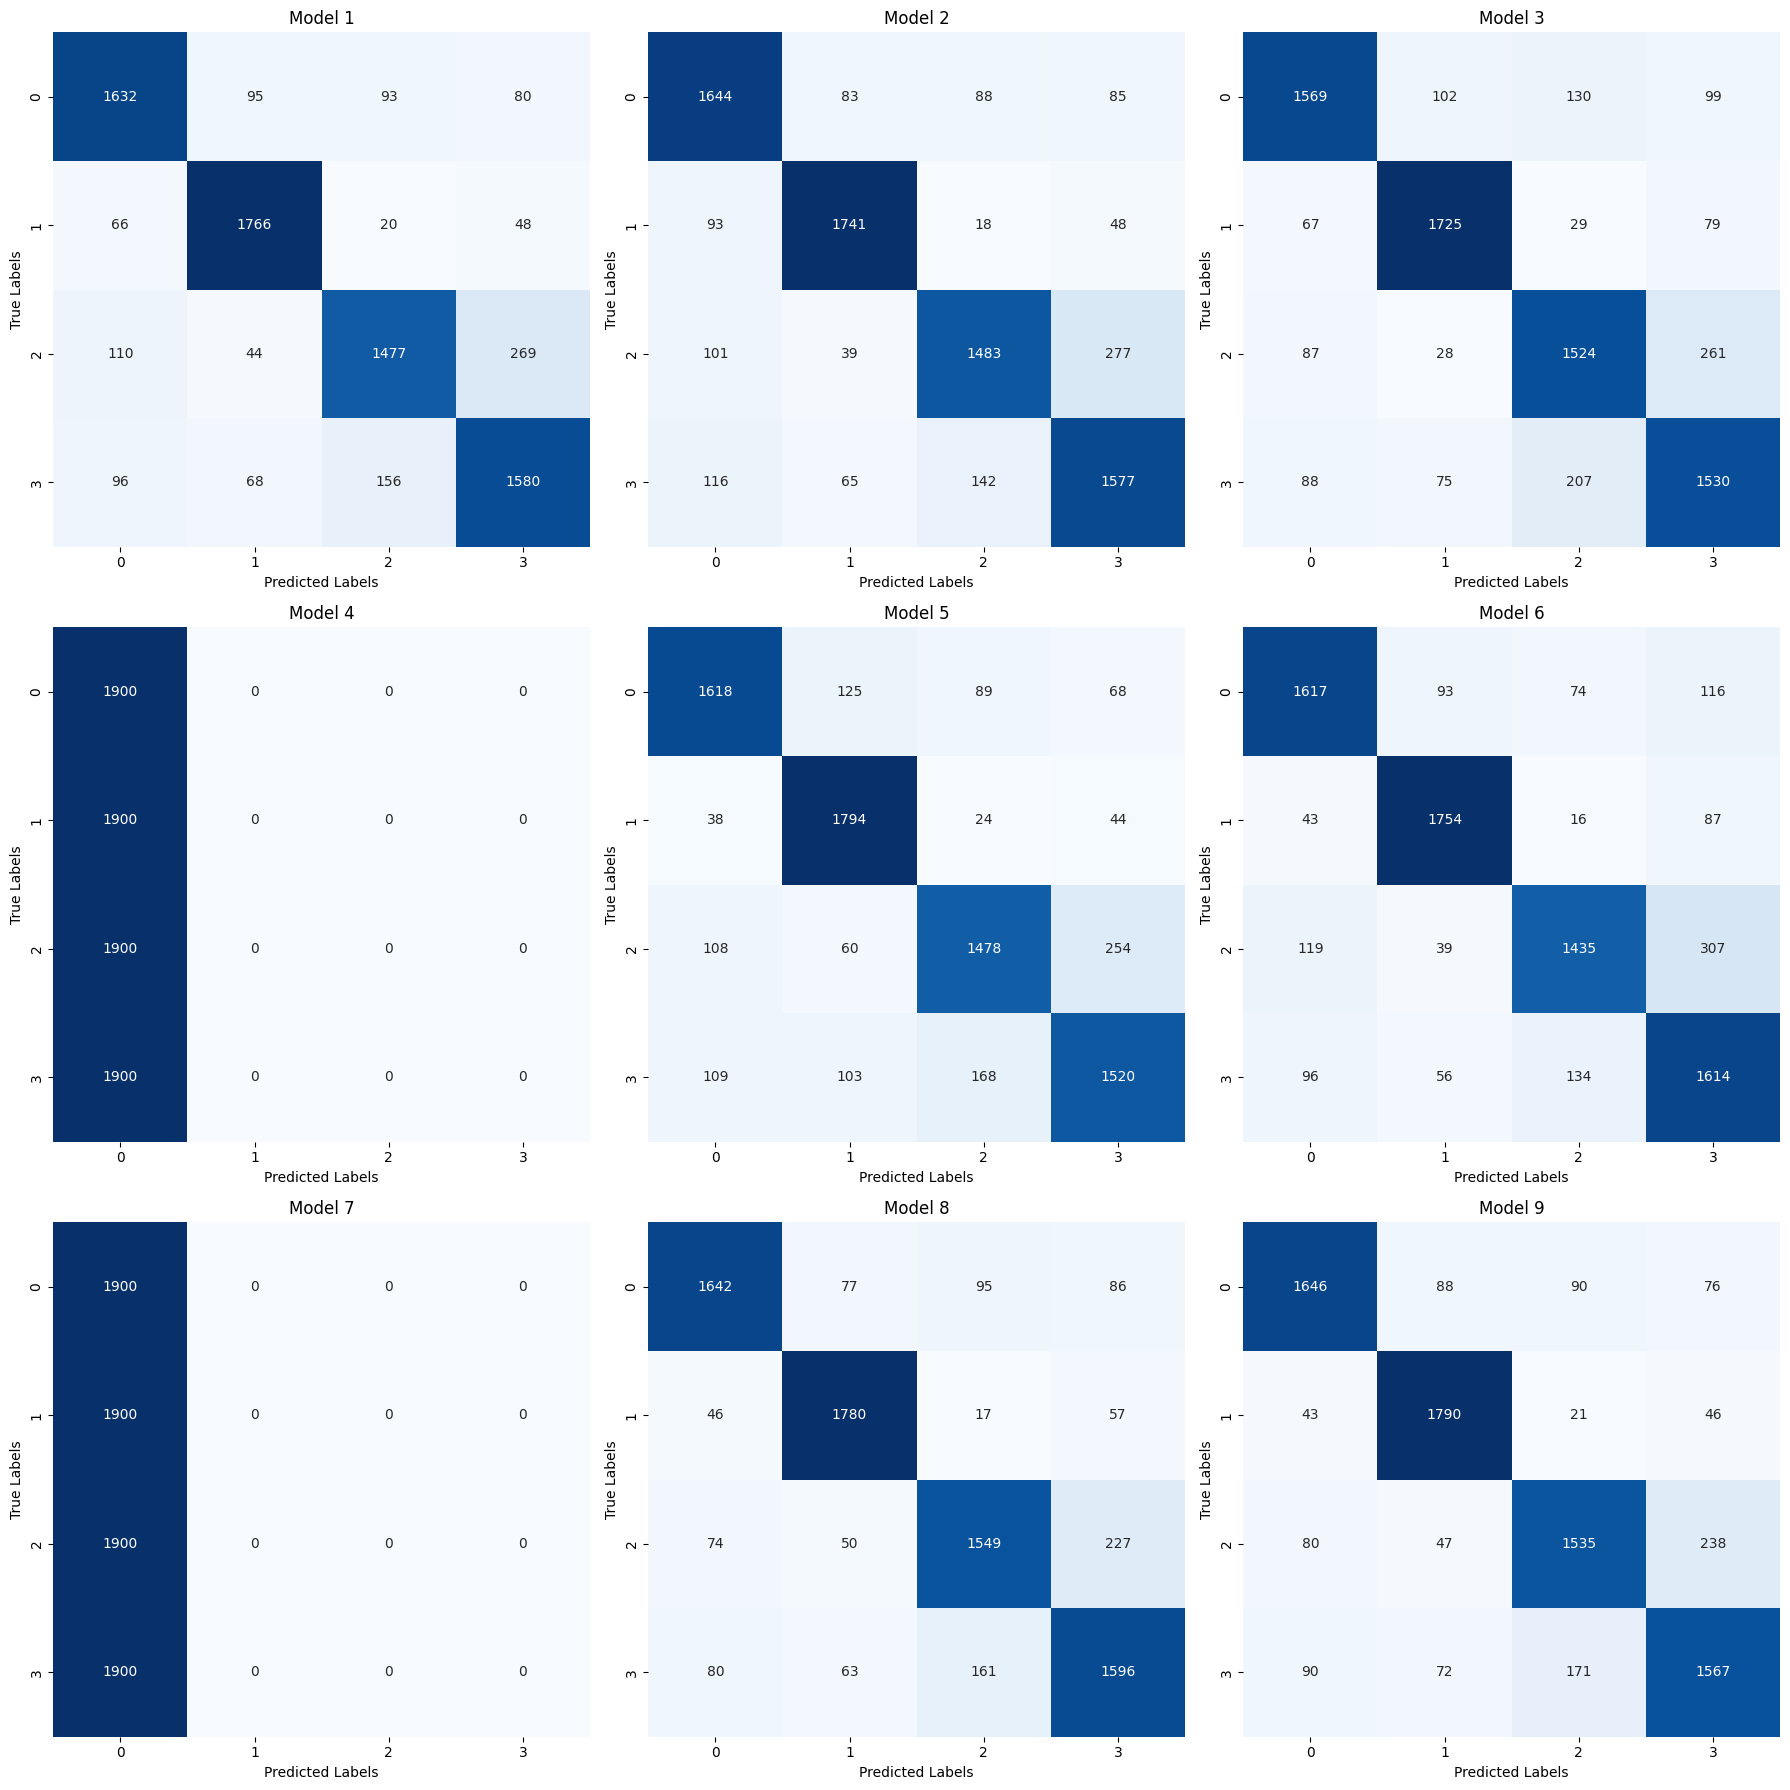

In [39]:
plot_confusion_matrices(
    [pred_one,
    pred_two,
    pred_three,
    pred_four,
    pred_five,
    pred_six,
    pred_seven,
    pred_eight,
    pred_nine,
    #pred_ten,
    ]
    ,y_test
)